# eqGAN Training Notebook

An attempt to perform automatic music mastering using a Generative Adversarial Network

### Make sure that these constants are set correctly!

In [16]:
# Constants
USING_GPU = True
AVAILABLE_GPUS="8"
CUDANO = 0

LR = 1e-3
EPOCHS = 2
IS_DIRECT = True # Direct or Indirect Reconstruction (See Paper for more details)
SAMPLE_LENGTH = 110229 # Less than 661794


RUN_NAME = 'example_run_1'

You should (hopefully) be able to run the rest of the cells without editing anything

In [17]:
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import numpy as np

## Download the dataset

In [18]:
# Construct a torch.utils.data.Dataset and DataLoader
gtzan_data = torchaudio.datasets.GTZAN('.', download=False)
gtzan_loader = torch.utils.data.DataLoader(gtzan_data, batch_size=1, shuffle=False, num_workers=6)

In [19]:
def visualize_wav(waveform, domain='time'):
    """
    A function to visualize a waveform in the time or frequency domain
    """
    wav = torch.squeeze(waveform, dim=0)
    if domain == 'freq':
        plt.figure(figsize=(50,30))
        specgram = torchaudio.transforms.Spectrogram()(wav)
        plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
    elif domain == 'time':
        plt.figure()
        plt.plot(wav.t().numpy())
    else:
        print('Invalid domain')

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: tensor([22050])


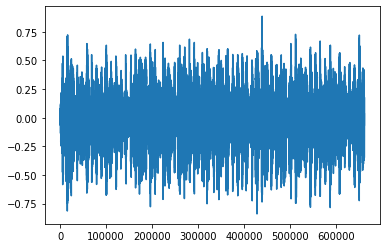

In [20]:
# Show a single example
example_wav, example_sr = None, None
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))
    example_wav, example_sr = waveform, sample_rate

    visualize_wav(waveform)
    break

### Implement EQ operations

In [21]:
# Define the EQ transform
from scipy.stats import loguniform

class RandomEQ(object):
    """EQ the waveform in a sample randomly.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, sample_rate):
        assert isinstance(sample_rate, (float, int))
        self.sample_rate = sample_rate
        
        # EQ Constants
        self.FREQ_RANGE = [0.01, 20] # in kHZ
        self.GAIN_RANGE = [-15, 15] # in dB
        self.Q_RANGE = [0.1, 18]

    def __call__(self, waveform, verbose=False):
        # TODO: Make some of these normals
        center_freq = loguniform.rvs(self.FREQ_RANGE[0], self.FREQ_RANGE[1])
        gain = np.random.uniform(self.GAIN_RANGE[0], self.GAIN_RANGE[1])
        Q = np.random.uniform(self.Q_RANGE[0], self.Q_RANGE[1])

        center_freq = 1
        gain = -10
        Q = 1
        
        if verbose:
            print(
                f"Applying random EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

        equalized_waveform = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        ) 

        return equalized_waveform

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: tensor([22050])


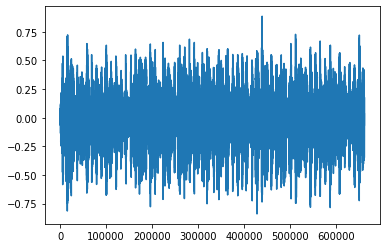

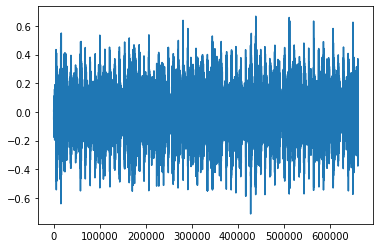

In [22]:
# Show a single example
eq_transform = RandomEQ(int(example_sr[0]))
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    visualize_wav(waveform)
    visualize_wav(eq_transform(waveform))
    break

### Learn an EQ operation

We want to test whether or not we can have a model learn an EQ operation by reconstructing the non-equalized version of the waveform

In [26]:
import os

device = 'cpu'

if USING_GPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=AVAILABLE_GPUS
    device = f'cuda:{CUDANO}'

if not os.path.exists(f"EQ/{RUN_NAME}"):
    os.mkdir(f"EQ/{RUN_NAME}")

In [27]:
class EQReconstructor(torch.nn.Module):
    def __init__(self, sample_rate, sample_length, direct=False):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.direct = direct
        self.indirect = not direct

        self.synthetic_transform = RandomEQ(self.sample_rate)
        self.indirect_rnn = torch.nn.LSTM(input_size=1, hidden_size=3, num_layers=1)
        self.direct_rnn = torch.nn.LSTM(input_size=1, hidden_size=1, num_layers=1)
        
        #self.gain = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_min = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_max = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_mean = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_rmse = torch.nn.parameter.Parameter(torch.tensor(1.0))

        self.criterion = torch.nn.MSELoss()
        
        self.activation = torch.nn.Tanh()

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, apply a random
        EQ, and then try to reconstruct it
        """
        # print("Pre-processing wav")
        with torch.no_grad():
            equalized_wav = self.synthetic_transform(waveform)

        if self.direct:
            # Run through the rnn
            output, (hn, cn) = self.direct_rnn(equalized_wav)
            
            # Get some stats from the output to figure out how much to boost gain            
            gain = output.min()*self.gain_min + output.max()*self.gain_max + output.mean()*self.gain_mean + torch.pow(output, 2).mean()*self.gain_rmse
            
            # Boost the gain
            reconstructed_wav = output*gain
            
            return reconstructed_wav

        if self.indirect:
            # print("Sharding waveform")
            wav_length = waveform.shape[0]
            num_seconds = 5
            num_shards = int(wav_length / (self.sample_rate*num_seconds)) + 1

            center_freq = torch.tensor(0., requires_grad=True)
            gain = torch.tensor(0., requires_grad=True)
            Q = torch.tensor(0., requires_grad=True)
            for i in range(num_shards):
                # print(f"Running LSTM on shard {i+1}/{num_shards}")
                # Create shard
                start_idx = i*self.sample_rate
                end_idx = (i+1)*self.sample_rate
                if end_idx >= wav_length:
                    end_idx = -1
                shard = equalized_wav[start_idx:end_idx,:,:]

                # Run LTSM
                output, (hn, cn) = self.indirect_rnn(shard)

                # Add vals to running sum
                center_freq = center_freq + hn[0,0,0]
                gain = gain + hn[0,0,1]
                Q = Q + hn[0,0,2]

            # Divide by number of runs
            center_freq /= num_shards
            gain /= num_shards
            Q /= num_shards

            print(
                f"Predicted EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

            return center_freq, gain, Q

    def loss(self, output, waveform):
        """
        Here we define the loss function that the model will try to optimize.
        In this case, a simple reconstruction loss
        """
        if direct:
            reconstructed_wav = output
        if indirect:
            center_freq, gain, Q = output
            reconstructed_wav = torchaudio.functional.equalizer_biquad(
                waveform, self.sample_rate,
                center_freq=center_freq*1e3, gain=gain, Q=Q
            )
        loss = criterion(waveform, reconstructed_wav)
        return loss


In [31]:
criterion = torch.nn.MSELoss()
def loss_function(output, waveform, direct=False):
    """
    Here we define the loss function that the model will try to optimize.
    In this case, a simple reconstruction loss
    """
    if direct:
        reconstructed_wav = output
    if not direct:
        center_freq, gain, Q = output
        reconstructed_wav = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        )
    loss = criterion(waveform, reconstructed_wav)
    loss += 0.05*torch.pow(waveform.max() - reconstructed_wav.max(), 2) # Penalize differences in max
    loss += 0.05*torch.pow(waveform.min() - reconstructed_wav.min(), 2)# Penalize differences in min
    return loss

In [32]:
model = EQReconstructor(sample_rate=22050, sample_length=SAMPLE_LENGTH, direct=IS_DIRECT).to(device) #661794
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    print("Let's use", num_gpus , "GPUs!")
    model = torch.nn.DataParallel(model)
    
for i in range(num_gpus):
    print("Device ", i, torch.cuda.get_device_name(i))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(i)/1024**3,1), 'GB')
    
# print(os.popen("source cuda10.0").read())

# print(os.popen("nvidia-htop.py").read())
# print(os.popen("nvidia-smi").read())

Device  0 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Epoch 0/2
Processing batch 1/1000


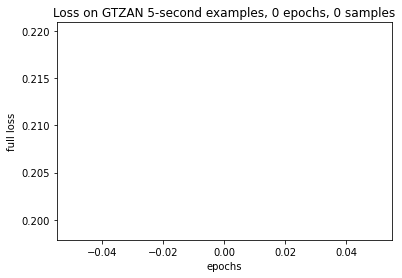

Processing batch 2/1000
Processing batch 3/1000
Processing batch 4/1000
Processing batch 5/1000
Processing batch 6/1000
Processing batch 7/1000
Processing batch 8/1000
Processing batch 9/1000
Processing batch 10/1000
Processing batch 11/1000
Processing batch 12/1000
Processing batch 13/1000
Processing batch 14/1000
Processing batch 15/1000
Processing batch 16/1000
Processing batch 17/1000
Processing batch 18/1000
Processing batch 19/1000
Processing batch 20/1000
Processing batch 21/1000
Processing batch 22/1000
Processing batch 23/1000
Processing batch 24/1000
Processing batch 25/1000
Processing batch 26/1000
Processing batch 27/1000
Processing batch 28/1000
Processing batch 29/1000
Processing batch 30/1000
Processing batch 31/1000
Processing batch 32/1000
Processing batch 33/1000
Processing batch 34/1000
Processing batch 35/1000
Processing batch 36/1000
Processing batch 37/1000
Processing batch 38/1000
Processing batch 39/1000
Processing batch 40/1000
Processing batch 41/1000
Processi

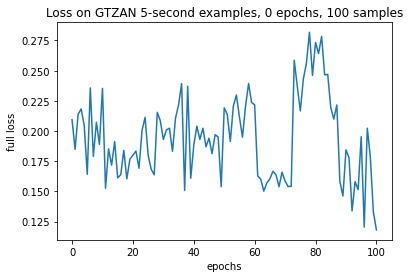

Processing batch 102/1000
Processing batch 103/1000
Processing batch 104/1000
Processing batch 105/1000
Processing batch 106/1000
Processing batch 107/1000
Processing batch 108/1000
Processing batch 109/1000
Processing batch 110/1000
Processing batch 111/1000
Processing batch 112/1000
Processing batch 113/1000
Processing batch 114/1000
Processing batch 115/1000
Processing batch 116/1000
Processing batch 117/1000
Processing batch 118/1000
Processing batch 119/1000
Processing batch 120/1000
Processing batch 121/1000
Processing batch 122/1000
Processing batch 123/1000
Processing batch 124/1000
Processing batch 125/1000
Processing batch 126/1000
Processing batch 127/1000
Processing batch 128/1000
Processing batch 129/1000
Processing batch 130/1000
Processing batch 131/1000
Processing batch 132/1000
Processing batch 133/1000
Processing batch 134/1000
Processing batch 135/1000
Processing batch 136/1000
Processing batch 137/1000
Processing batch 138/1000
Processing batch 139/1000
Processing b

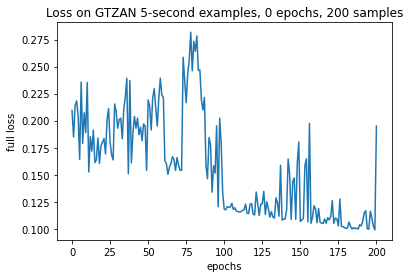

Processing batch 202/1000
Processing batch 203/1000
Processing batch 204/1000
Processing batch 205/1000
Processing batch 206/1000
Processing batch 207/1000
Processing batch 208/1000
Processing batch 209/1000
Processing batch 210/1000
Processing batch 211/1000
Processing batch 212/1000
Processing batch 213/1000
Processing batch 214/1000
Processing batch 215/1000
Processing batch 216/1000
Processing batch 217/1000
Processing batch 218/1000
Processing batch 219/1000
Processing batch 220/1000
Processing batch 221/1000
Processing batch 222/1000
Processing batch 223/1000
Processing batch 224/1000
Processing batch 225/1000
Processing batch 226/1000
Processing batch 227/1000
Processing batch 228/1000
Processing batch 229/1000
Processing batch 230/1000
Processing batch 231/1000
Processing batch 232/1000
Processing batch 233/1000
Processing batch 234/1000
Processing batch 235/1000
Processing batch 236/1000
Processing batch 237/1000
Processing batch 238/1000
Processing batch 239/1000
Processing b

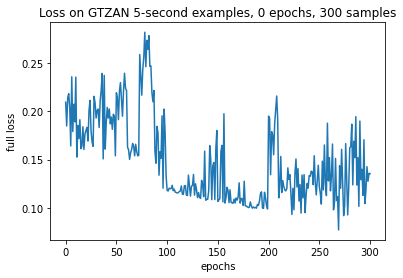

Processing batch 302/1000
Processing batch 303/1000
Processing batch 304/1000
Processing batch 305/1000
Processing batch 306/1000
Processing batch 307/1000
Processing batch 308/1000
Processing batch 309/1000
Processing batch 310/1000
Processing batch 311/1000
Processing batch 312/1000
Processing batch 313/1000
Processing batch 314/1000
Processing batch 315/1000
Processing batch 316/1000
Processing batch 317/1000
Processing batch 318/1000
Processing batch 319/1000
Processing batch 320/1000
Processing batch 321/1000
Processing batch 322/1000
Processing batch 323/1000
Processing batch 324/1000
Processing batch 325/1000
Processing batch 326/1000
Processing batch 327/1000
Processing batch 328/1000
Processing batch 329/1000
Processing batch 330/1000
Processing batch 331/1000
Processing batch 332/1000
Processing batch 333/1000
Processing batch 334/1000
Processing batch 335/1000
Processing batch 336/1000
Processing batch 337/1000
Processing batch 338/1000
Processing batch 339/1000
Processing b

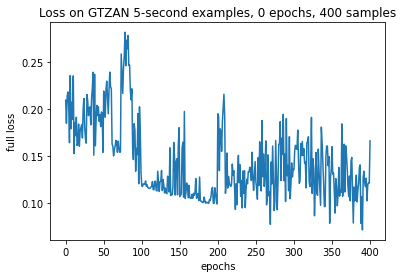

Processing batch 402/1000
Processing batch 403/1000
Processing batch 404/1000
Processing batch 405/1000
Processing batch 406/1000
Processing batch 407/1000
Processing batch 408/1000
Processing batch 409/1000
Processing batch 410/1000
Processing batch 411/1000
Processing batch 412/1000
Processing batch 413/1000
Processing batch 414/1000
Processing batch 415/1000
Processing batch 416/1000
Processing batch 417/1000
Processing batch 418/1000
Processing batch 419/1000
Processing batch 420/1000
Processing batch 421/1000
Processing batch 422/1000
Processing batch 423/1000
Processing batch 424/1000
Processing batch 425/1000
Processing batch 426/1000
Processing batch 427/1000
Processing batch 428/1000
Processing batch 429/1000
Processing batch 430/1000
Processing batch 431/1000
Processing batch 432/1000
Processing batch 433/1000
Processing batch 434/1000
Processing batch 435/1000
Processing batch 436/1000
Processing batch 437/1000
Processing batch 438/1000
Processing batch 439/1000
Processing b

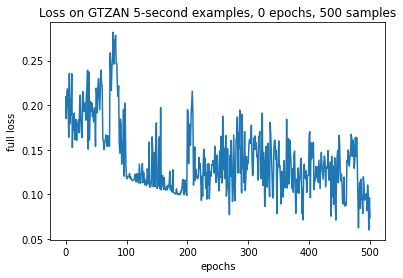

Processing batch 502/1000
Processing batch 503/1000
Processing batch 504/1000
Processing batch 505/1000
Processing batch 506/1000
Processing batch 507/1000
Processing batch 508/1000
Processing batch 509/1000
Processing batch 510/1000
Processing batch 511/1000
Processing batch 512/1000
Processing batch 513/1000
Processing batch 514/1000
Processing batch 515/1000
Processing batch 516/1000
Processing batch 517/1000
Processing batch 518/1000
Processing batch 519/1000
Processing batch 520/1000
Processing batch 521/1000
Processing batch 522/1000
Processing batch 523/1000
Processing batch 524/1000
Processing batch 525/1000
Processing batch 526/1000
Processing batch 527/1000
Processing batch 528/1000
Processing batch 529/1000
Processing batch 530/1000
Processing batch 531/1000
Processing batch 532/1000
Processing batch 533/1000
Processing batch 534/1000
Processing batch 535/1000
Processing batch 536/1000
Processing batch 537/1000
Processing batch 538/1000
Processing batch 539/1000
Processing b

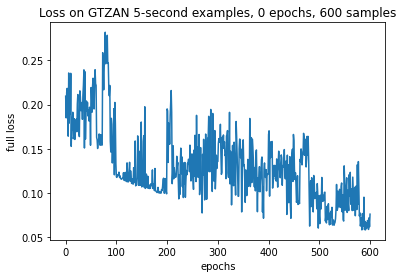

Processing batch 602/1000
Processing batch 603/1000
Processing batch 604/1000
Processing batch 605/1000
Processing batch 606/1000
Processing batch 607/1000
Processing batch 608/1000
Processing batch 609/1000
Processing batch 610/1000
Processing batch 611/1000
Processing batch 612/1000
Processing batch 613/1000
Processing batch 614/1000
Processing batch 615/1000
Processing batch 616/1000
Processing batch 617/1000
Processing batch 618/1000
Processing batch 619/1000
Processing batch 620/1000
Processing batch 621/1000
Processing batch 622/1000
Processing batch 623/1000
Processing batch 624/1000
Processing batch 625/1000
Processing batch 626/1000
Processing batch 627/1000
Processing batch 628/1000
Processing batch 629/1000
Processing batch 630/1000
Processing batch 631/1000
Processing batch 632/1000
Processing batch 633/1000
Processing batch 634/1000
Processing batch 635/1000
Processing batch 636/1000
Processing batch 637/1000
Processing batch 638/1000
Processing batch 639/1000
Processing b

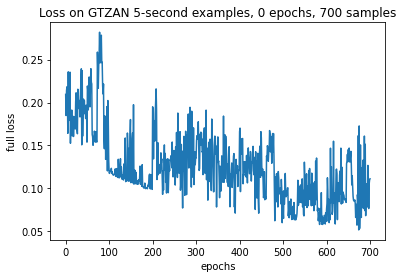

Processing batch 702/1000
Processing batch 703/1000
Processing batch 704/1000
Processing batch 705/1000
Processing batch 706/1000
Processing batch 707/1000
Processing batch 708/1000
Processing batch 709/1000
Processing batch 710/1000
Processing batch 711/1000
Processing batch 712/1000
Processing batch 713/1000
Processing batch 714/1000
Processing batch 715/1000
Processing batch 716/1000
Processing batch 717/1000
Processing batch 718/1000
Processing batch 719/1000
Processing batch 720/1000
Processing batch 721/1000
Processing batch 722/1000
Processing batch 723/1000
Processing batch 724/1000
Processing batch 725/1000
Processing batch 726/1000
Processing batch 727/1000
Processing batch 728/1000
Processing batch 729/1000
Processing batch 730/1000
Processing batch 731/1000
Processing batch 732/1000
Processing batch 733/1000
Processing batch 734/1000
Processing batch 735/1000
Processing batch 736/1000
Processing batch 737/1000
Processing batch 738/1000
Processing batch 739/1000
Processing b

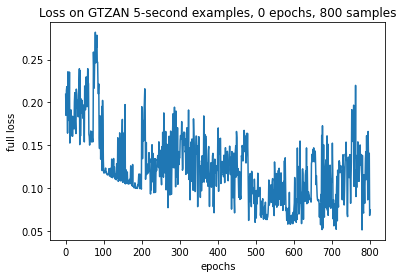

Processing batch 802/1000
Processing batch 803/1000
Processing batch 804/1000
Processing batch 805/1000
Processing batch 806/1000
Processing batch 807/1000
Processing batch 808/1000
Processing batch 809/1000
Processing batch 810/1000
Processing batch 811/1000
Processing batch 812/1000
Processing batch 813/1000
Processing batch 814/1000
Processing batch 815/1000
Processing batch 816/1000
Processing batch 817/1000
Processing batch 818/1000
Processing batch 819/1000
Processing batch 820/1000
Processing batch 821/1000
Processing batch 822/1000
Processing batch 823/1000
Processing batch 824/1000
Processing batch 825/1000
Processing batch 826/1000
Processing batch 827/1000
Processing batch 828/1000
Processing batch 829/1000
Processing batch 830/1000
Processing batch 831/1000
Processing batch 832/1000
Processing batch 833/1000
Processing batch 834/1000
Processing batch 835/1000
Processing batch 836/1000
Processing batch 837/1000
Processing batch 838/1000
Processing batch 839/1000
Processing b

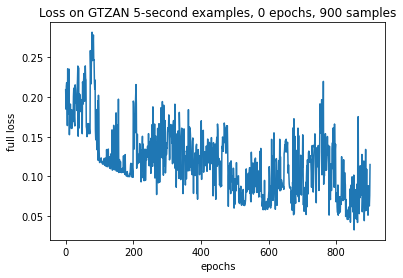

Processing batch 902/1000
Processing batch 903/1000
Processing batch 904/1000
Processing batch 905/1000
Processing batch 906/1000
Processing batch 907/1000
Processing batch 908/1000
Processing batch 909/1000
Processing batch 910/1000
Processing batch 911/1000
Processing batch 912/1000
Processing batch 913/1000
Processing batch 914/1000
Processing batch 915/1000
Processing batch 916/1000
Processing batch 917/1000
Processing batch 918/1000
Processing batch 919/1000
Processing batch 920/1000
Processing batch 921/1000
Processing batch 922/1000
Processing batch 923/1000
Processing batch 924/1000
Processing batch 925/1000
Processing batch 926/1000
Processing batch 927/1000
Processing batch 928/1000
Processing batch 929/1000
Processing batch 930/1000
Processing batch 931/1000
Processing batch 932/1000
Processing batch 933/1000
Processing batch 934/1000
Processing batch 935/1000
Processing batch 936/1000
Processing batch 937/1000
Processing batch 938/1000
Processing batch 939/1000
Processing b

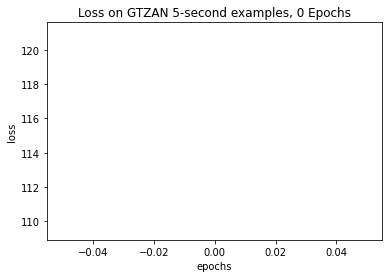

Epoch [0/2], loss: 115.25930723920465
Epoch 1/2
Processing batch 1/1000


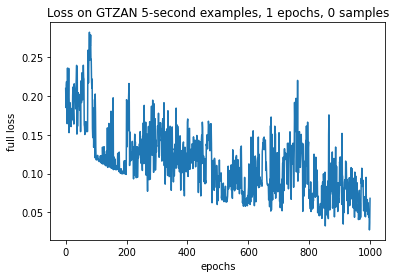

Processing batch 2/1000
Processing batch 3/1000
Processing batch 4/1000
Processing batch 5/1000
Processing batch 6/1000
Processing batch 7/1000
Processing batch 8/1000
Processing batch 9/1000
Processing batch 10/1000
Processing batch 11/1000
Processing batch 12/1000
Processing batch 13/1000
Processing batch 14/1000
Processing batch 15/1000
Processing batch 16/1000
Processing batch 17/1000
Processing batch 18/1000
Processing batch 19/1000
Processing batch 20/1000
Processing batch 21/1000
Processing batch 22/1000
Processing batch 23/1000
Processing batch 24/1000
Processing batch 25/1000
Processing batch 26/1000
Processing batch 27/1000
Processing batch 28/1000
Processing batch 29/1000
Processing batch 30/1000
Processing batch 31/1000
Processing batch 32/1000
Processing batch 33/1000
Processing batch 34/1000
Processing batch 35/1000
Processing batch 36/1000
Processing batch 37/1000
Processing batch 38/1000
Processing batch 39/1000
Processing batch 40/1000
Processing batch 41/1000
Processi

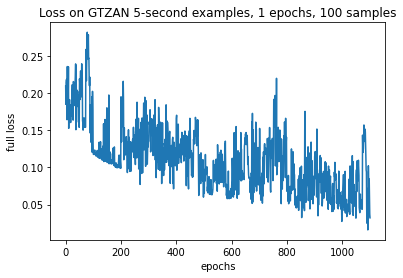

Processing batch 102/1000
Processing batch 103/1000
Processing batch 104/1000
Processing batch 105/1000
Processing batch 106/1000
Processing batch 107/1000
Processing batch 108/1000
Processing batch 109/1000
Processing batch 110/1000
Processing batch 111/1000
Processing batch 112/1000
Processing batch 113/1000
Processing batch 114/1000
Processing batch 115/1000
Processing batch 116/1000
Processing batch 117/1000
Processing batch 118/1000
Processing batch 119/1000
Processing batch 120/1000
Processing batch 121/1000
Processing batch 122/1000
Processing batch 123/1000
Processing batch 124/1000
Processing batch 125/1000
Processing batch 126/1000
Processing batch 127/1000
Processing batch 128/1000
Processing batch 129/1000
Processing batch 130/1000
Processing batch 131/1000
Processing batch 132/1000
Processing batch 133/1000
Processing batch 134/1000
Processing batch 135/1000
Processing batch 136/1000
Processing batch 137/1000
Processing batch 138/1000
Processing batch 139/1000
Processing b

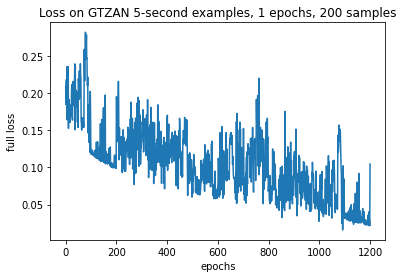

Processing batch 202/1000
Processing batch 203/1000
Processing batch 204/1000
Processing batch 205/1000
Processing batch 206/1000
Processing batch 207/1000
Processing batch 208/1000
Processing batch 209/1000
Processing batch 210/1000
Processing batch 211/1000
Processing batch 212/1000
Processing batch 213/1000
Processing batch 214/1000
Processing batch 215/1000
Processing batch 216/1000
Processing batch 217/1000
Processing batch 218/1000
Processing batch 219/1000
Processing batch 220/1000
Processing batch 221/1000
Processing batch 222/1000
Processing batch 223/1000
Processing batch 224/1000
Processing batch 225/1000
Processing batch 226/1000
Processing batch 227/1000
Processing batch 228/1000
Processing batch 229/1000
Processing batch 230/1000
Processing batch 231/1000
Processing batch 232/1000
Processing batch 233/1000
Processing batch 234/1000
Processing batch 235/1000
Processing batch 236/1000
Processing batch 237/1000
Processing batch 238/1000
Processing batch 239/1000
Processing b

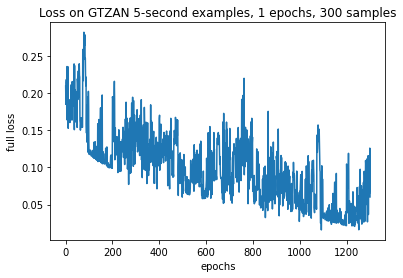

Processing batch 302/1000
Processing batch 303/1000
Processing batch 304/1000
Processing batch 305/1000
Processing batch 306/1000
Processing batch 307/1000
Processing batch 308/1000
Processing batch 309/1000
Processing batch 310/1000
Processing batch 311/1000
Processing batch 312/1000
Processing batch 313/1000
Processing batch 314/1000
Processing batch 315/1000
Processing batch 316/1000
Processing batch 317/1000
Processing batch 318/1000
Processing batch 319/1000
Processing batch 320/1000
Processing batch 321/1000
Processing batch 322/1000
Processing batch 323/1000
Processing batch 324/1000
Processing batch 325/1000
Processing batch 326/1000
Processing batch 327/1000
Processing batch 328/1000
Processing batch 329/1000
Processing batch 330/1000
Processing batch 331/1000
Processing batch 332/1000
Processing batch 333/1000
Processing batch 334/1000
Processing batch 335/1000
Processing batch 336/1000
Processing batch 337/1000
Processing batch 338/1000
Processing batch 339/1000
Processing b

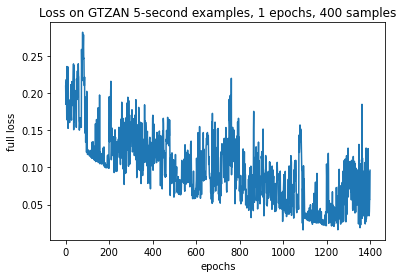

Processing batch 402/1000
Processing batch 403/1000
Processing batch 404/1000
Processing batch 405/1000
Processing batch 406/1000
Processing batch 407/1000
Processing batch 408/1000
Processing batch 409/1000
Processing batch 410/1000
Processing batch 411/1000
Processing batch 412/1000
Processing batch 413/1000
Processing batch 414/1000
Processing batch 415/1000
Processing batch 416/1000
Processing batch 417/1000
Processing batch 418/1000
Processing batch 419/1000
Processing batch 420/1000
Processing batch 421/1000
Processing batch 422/1000
Processing batch 423/1000
Processing batch 424/1000
Processing batch 425/1000
Processing batch 426/1000
Processing batch 427/1000
Processing batch 428/1000
Processing batch 429/1000
Processing batch 430/1000
Processing batch 431/1000
Processing batch 432/1000
Processing batch 433/1000
Processing batch 434/1000
Processing batch 435/1000
Processing batch 436/1000
Processing batch 437/1000
Processing batch 438/1000
Processing batch 439/1000
Processing b

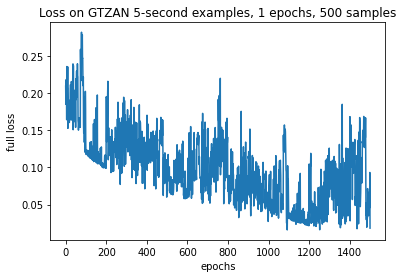

Processing batch 502/1000
Processing batch 503/1000
Processing batch 504/1000
Processing batch 505/1000
Processing batch 506/1000
Processing batch 507/1000
Processing batch 508/1000
Processing batch 509/1000
Processing batch 510/1000
Processing batch 511/1000
Processing batch 512/1000
Processing batch 513/1000
Processing batch 514/1000
Processing batch 515/1000
Processing batch 516/1000
Processing batch 517/1000
Processing batch 518/1000
Processing batch 519/1000
Processing batch 520/1000
Processing batch 521/1000
Processing batch 522/1000
Processing batch 523/1000
Processing batch 524/1000
Processing batch 525/1000
Processing batch 526/1000
Processing batch 527/1000
Processing batch 528/1000
Processing batch 529/1000
Processing batch 530/1000
Processing batch 531/1000
Processing batch 532/1000
Processing batch 533/1000
Processing batch 534/1000
Processing batch 535/1000
Processing batch 536/1000
Processing batch 537/1000
Processing batch 538/1000
Processing batch 539/1000
Processing b

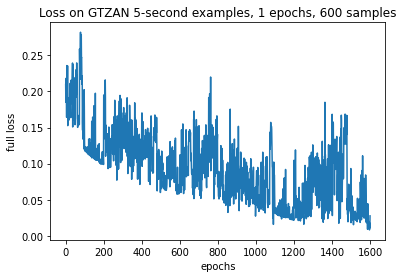

Processing batch 602/1000
Processing batch 603/1000
Processing batch 604/1000
Processing batch 605/1000
Processing batch 606/1000
Processing batch 607/1000
Processing batch 608/1000
Processing batch 609/1000
Processing batch 610/1000
Processing batch 611/1000
Processing batch 612/1000
Processing batch 613/1000
Processing batch 614/1000
Processing batch 615/1000
Processing batch 616/1000
Processing batch 617/1000
Processing batch 618/1000
Processing batch 619/1000
Processing batch 620/1000
Processing batch 621/1000
Processing batch 622/1000
Processing batch 623/1000
Processing batch 624/1000
Processing batch 625/1000
Processing batch 626/1000
Processing batch 627/1000
Processing batch 628/1000
Processing batch 629/1000
Processing batch 630/1000
Processing batch 631/1000
Processing batch 632/1000
Processing batch 633/1000
Processing batch 634/1000
Processing batch 635/1000
Processing batch 636/1000
Processing batch 637/1000
Processing batch 638/1000
Processing batch 639/1000
Processing b

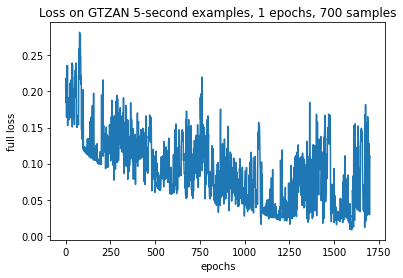

Processing batch 702/1000
Processing batch 703/1000
Processing batch 704/1000
Processing batch 705/1000
Processing batch 706/1000
Processing batch 707/1000
Processing batch 708/1000
Processing batch 709/1000
Processing batch 710/1000
Processing batch 711/1000
Processing batch 712/1000
Processing batch 713/1000
Processing batch 714/1000
Processing batch 715/1000
Processing batch 716/1000
Processing batch 717/1000
Processing batch 718/1000
Processing batch 719/1000
Processing batch 720/1000
Processing batch 721/1000
Processing batch 722/1000
Processing batch 723/1000
Processing batch 724/1000
Processing batch 725/1000
Processing batch 726/1000
Processing batch 727/1000
Processing batch 728/1000
Processing batch 729/1000
Processing batch 730/1000
Processing batch 731/1000
Processing batch 732/1000
Processing batch 733/1000
Processing batch 734/1000
Processing batch 735/1000
Processing batch 736/1000
Processing batch 737/1000
Processing batch 738/1000
Processing batch 739/1000
Processing b

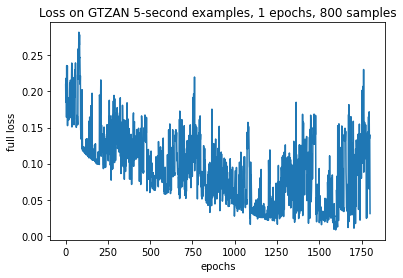

Processing batch 802/1000
Processing batch 803/1000
Processing batch 804/1000
Processing batch 805/1000
Processing batch 806/1000
Processing batch 807/1000
Processing batch 808/1000
Processing batch 809/1000
Processing batch 810/1000
Processing batch 811/1000
Processing batch 812/1000
Processing batch 813/1000
Processing batch 814/1000
Processing batch 815/1000
Processing batch 816/1000
Processing batch 817/1000
Processing batch 818/1000
Processing batch 819/1000
Processing batch 820/1000
Processing batch 821/1000
Processing batch 822/1000
Processing batch 823/1000
Processing batch 824/1000
Processing batch 825/1000
Processing batch 826/1000
Processing batch 827/1000
Processing batch 828/1000
Processing batch 829/1000
Processing batch 830/1000
Processing batch 831/1000
Processing batch 832/1000
Processing batch 833/1000
Processing batch 834/1000
Processing batch 835/1000
Processing batch 836/1000
Processing batch 837/1000
Processing batch 838/1000
Processing batch 839/1000
Processing b

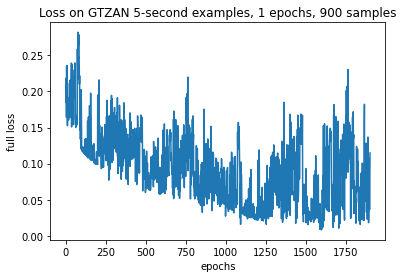

Processing batch 902/1000
Processing batch 903/1000
Processing batch 904/1000
Processing batch 905/1000
Processing batch 906/1000
Processing batch 907/1000
Processing batch 908/1000
Processing batch 909/1000
Processing batch 910/1000
Processing batch 911/1000
Processing batch 912/1000
Processing batch 913/1000
Processing batch 914/1000
Processing batch 915/1000
Processing batch 916/1000
Processing batch 917/1000
Processing batch 918/1000
Processing batch 919/1000
Processing batch 920/1000
Processing batch 921/1000
Processing batch 922/1000
Processing batch 923/1000
Processing batch 924/1000
Processing batch 925/1000
Processing batch 926/1000
Processing batch 927/1000
Processing batch 928/1000
Processing batch 929/1000
Processing batch 930/1000
Processing batch 931/1000
Processing batch 932/1000
Processing batch 933/1000
Processing batch 934/1000
Processing batch 935/1000
Processing batch 936/1000
Processing batch 937/1000
Processing batch 938/1000
Processing batch 939/1000
Processing b

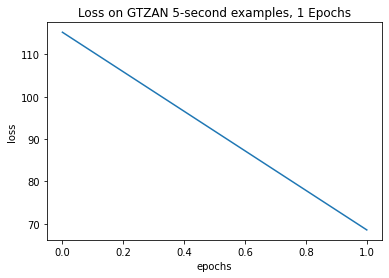

Epoch [1/2], loss: 68.536202439107


In [33]:
full_losses = []
losses = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}/{EPOCHS}")
    epoch_loss = 0
    for idx, batch in enumerate(gtzan_loader):
        # Extract data
        print(f"Processing batch {idx+1}/{len(gtzan_loader)}")
        waveform, sample_rate, label = batch
        sample_rate = sample_rate[0].item()

        # Forward pass
        wav = torch.transpose(waveform, 0, -1)
        wav = wav[:SAMPLE_LENGTH,:,:].to(device)
        output = model(wav)
        
        if idx == 0:
            eq = RandomEQ(sample_rate)
            torchaudio.save(
                f'EQ/{RUN_NAME}/sample_original.wav',
                torch.squeeze(torch.transpose(wav.to('cpu'), 0, 1), axis=-1),
                sample_rate
            )
            torchaudio.save(
                f'EQ/{RUN_NAME}/sample_eqd.wav',
                torch.squeeze(torch.transpose(eq(wav).to('cpu'), 0, 1), axis=-1),
                sample_rate
            )
            torchaudio.save(
                f'EQ/{RUN_NAME}/sample_reconstructed_{epoch}.wav',
                torch.squeeze(torch.transpose(output.to('cpu'), 0, 1), axis=-1),
                sample_rate
            )

        # Compute and print loss
        loss = loss_function(output, wav, direct=IS_DIRECT)
        epoch_loss += loss.item()
        full_losses += [loss.item()]
        
        if idx % 100 == 0:
            plt.plot(full_losses)
            plt.ylabel('full loss')
            plt.xlabel('epochs')
            plt.title(f'Loss on GTZAN 5-second examples, {epoch} epochs, {idx} samples')
            plt.show()
            
            torch.save({
                "model": model.state_dict(),
                "opt": optimizer.state_dict(),
                "hyperparameters": {
                    "epochs": EPOCHS,
                    "sample_rate": 22050,
                    "sample_length": SAMPLE_LENGTH,
                    "direct": IS_DIRECT,
                    "lr": LR,
                },
                "losses": losses,
                "full_losses": full_losses,
                "epochs": epoch,
                "idx": idx
            }, f'./{RUN_NAME}.pt')

        # Perform a backward pass, and update the weights.
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses += [epoch_loss]
       
    # Plot loss
    plt.plot(losses)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.title(f'Loss on GTZAN 5-second examples, {epoch} Epochs')
    plt.show()
    
    print(f"Epoch [{epoch}/{EPOCHS}], loss: {epoch_loss}")

In [34]:
checkpoint_path = f'./{RUN_NAME}.pt'

In [35]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model": model.state_dict(),
        "opt": optimizer.state_dict(),
        "hyperparameters": {
            "epochs": EPOCHS,
            "sample_rate": 22050,
            "sample_length": 110229,
            "direct": True,
            "lr": LR,
        },
        "losses": losses
    }, path)

In [36]:
save_checkpoint(model, optimizer, checkpoint_path)

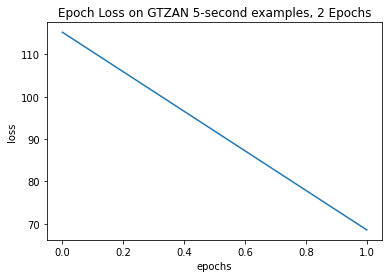

In [37]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title(f'Epoch Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_epoch_loss.png')

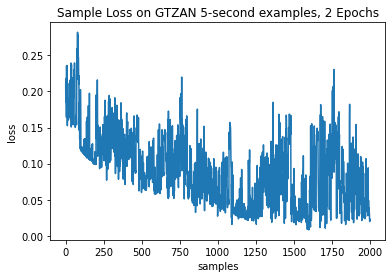

In [38]:
plt.plot(full_losses)
plt.ylabel('loss')
plt.xlabel('samples')
plt.title(f'Sample Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_sample_loss.png')